<a href="https://colab.research.google.com/github/ShaunakSen/Deep-Learning/blob/master/TensorFlow_Tutorial_02_Convolutional_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## TensorFlow Tutorial #02 Convolutional Neural Network

[link](https://www.youtube.com/watch?v=HMcx-zY8JSg&list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ&index=5&t=389s)

### Introduction

The previous tutorial showed that a simple linear model had about 91% classification accuracy for recognizing hand-written digits in the MNIST data-set.

In this tutorial we will implement a simple Convolutional Neural Network in TensorFlow which has a classification accuracy of about 99%, or more if you make some of the suggested exercises.

Convolutional Networks work by moving small filters across the input image. This means the filters are re-used for recognizing patterns throughout the entire input image. This makes the Convolutional Networks much more powerful than Fully-Connected networks with the same number of variables. This in turn makes the Convolutional Networks faster to train.

The following chart shows roughly how the data flows in the Convolutional Neural Network that is implemented below.


![](https://github.com/Hvass-Labs/TensorFlow-Tutorials/raw/0495ab11a7eef74c2637a9a3fc2ca4bd1eac9022/images/02_network_flowchart.png)

The input image is processed in the first convolutional layer using the filter-weights. This results in 16 new images, one for each filter in the convolutional layer. The images are also down-sampled so the image resolution is decreased from 28x28 to 14x14.

These 16 smaller images are then processed in the second convolutional layer. We need filter-weights for each of these 16 channels, and we need filter-weights for each output channel of this layer. There are 36 output channels so there are a total of 16 x 36 = 576 filters in the second convolutional layer. The resulting images are down-sampled again to 7x7 pixels.

The output of the second convolutional layer is 36 images of 7x7 pixels each. These are then flattened to a single vector of length 7 x 7 x 36 = 1764, which is used as the input to a fully-connected layer with 128 neurons (or elements). This feeds into another fully-connected layer with 10 neurons, one for each of the classes, which is used to determine the class of the image, that is, which number is depicted in the image.

The convolutional filters are initially chosen at random, so the classification is done randomly. The error between the predicted and true class of the input image is measured as the so-called cross-entropy. The optimizer then automatically propagates this error back through the Convolutional Network using the chain-rule of differentiation and updates the filter-weights so as to improve the classification error. This is done iteratively thousands of times until the classification error is sufficiently low.

These particular filter-weights and intermediate images are the results of one optimization run and may look different if you re-run this Notebook.

Note that the computation in TensorFlow is actually done on a batch of images instead of a single image, which makes the computation more efficient. This means the flowchart actually has one more data-dimension when implemented in TensorFlow.

### Convolutional Layer

The following chart shows the basic idea of processing an image in the first convolutional layer. The input image depicts the number 7 and four copies of the image are shown here, so we can see more clearly how the filter is being moved to different positions of the image. For each position of the filter, the dot-product is being calculated between the filter and the image pixels under the filter, which results in a single pixel in the output image. So moving the filter across the entire input image results in a new image being generated.

The red filter-weights means that the filter has a positive reaction to black pixels in the input image, while blue pixels means the filter has a negative reaction to black pixels.

In this case it appears that the filter recognizes the horizontal line of the 7-digit, as can be seen from its stronger reaction to that line in the output image.

![](https://github.com/Hvass-Labs/TensorFlow-Tutorials/raw/0495ab11a7eef74c2637a9a3fc2ca4bd1eac9022/images/02_convolution.png)

The step-size for moving the filter across the input is called the stride. There is a stride for moving the filter horizontally (x-axis) and another stride for moving vertically (y-axis).

In the source-code below, the stride is set to 1 in both directions, which means the filter starts in the upper left corner of the input image and is being moved 1 pixel to the right in each step. When the filter reaches the end of the image to the right, then the filter is moved back to the left side and 1 pixel down the image. This continues until the filter has reached the lower right corner of the input image and the entire output image has been generated.

When the filter reaches the end of the right-side as well as the bottom of the input image, then it can be padded with zeroes (white pixels). This causes the output image to be of the exact same dimension as the input image.

Furthermore, the output of the convolution may be passed through a so-called Rectified Linear Unit (ReLU), which merely ensures that the output is positive because negative values are set to zero. The output may also be down-sampled by so-called max-pooling, which considers small windows of 2x2 pixels and only keeps the largest of those pixels. This halves the resolution of the input image e.g. from 28x28 to 14x14 pixels.

Note that the second convolutional layer is more complicated because it takes 16 input channels. We want a separate filter for each input channel, so we need 16 filters instead of just one. Furthermore, we want 36 output channels from the second convolutional layer, so in total we need 16 x 36 = 576 filters for the second convolutional layer. It can be a bit challenging to understand how this works.

### Imports

In [3]:
import os
work_dir = "/content/TensorFlow-Tutorials/"
if os.getcwd() != work_dir:
  !git clone https://github.com/Hvass-Labs/TensorFlow-Tutorials
os.chdir(work_dir)

Cloning into 'TensorFlow-Tutorials'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 477 (delta 1), reused 3 (delta 1), pack-reused 471
Receiving objects: 100% (477/477), 62.51 MiB | 40.93 MiB/s, done.
Resolving deltas: 100% (222/222), done.


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

print (tf.__version__)

1.14.0


### Configuration of Neural Network

The configuration of the Convolutional Neural Network is defined here for convenience, so you can easily find and change these numbers and re-run the Notebook.



In [0]:
# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

### Load data

In [4]:
from mnist import MNIST
data = MNIST(data_dir="data/MNIST/")

- Download progress: 100.0% Done!
- Download progress: 100.0% Done!
- Download progress: 100.0% Done!
- Download progress: 100.0% Done!


In [5]:

print("Size of:")
print("- Training-set:\t\t{}".format(data.num_train))
print("- Validation-set:\t{}".format(data.num_val))
print("- Test-set:\t\t{}".format(data.num_test))

Size of:
- Training-set:		55000
- Validation-set:	5000
- Test-set:		10000


In [6]:
# The number of pixels in each dimension of an image.
img_size = data.img_size

# The images are stored in one-dimensional arrays of this length.
img_size_flat = data.img_size_flat

# Tuple with height and width of images used to reshape arrays.
img_shape = data.img_shape

# Number of classes, one class for each of 10 digits.
num_classes = data.num_classes

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = data.num_channels

print (img_size, img_size_flat, img_shape, num_classes, num_channels)

28 784 (28, 28) 10 1


In [0]:
# Function used to plot 9 images in a 3x3 grid, and writing the true and predicted classes below each image.

def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

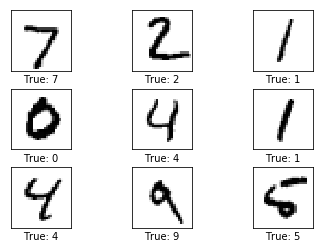

In [8]:
# Plot a few images to see if data is correct


# Get the first images from the test-set.
images = data.x_test[0:9]

# Get the true classes for those images.
cls_true = data.y_test_cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

### Helper-functions for creating new variables

Functions for creating new TensorFlow variables in the given shape and initializing them with random values. Note that the initialization is not actually done at this point, it is merely being defined in the TensorFlow graph.



In [0]:
def new_weights(shape):
  # truncated_normal: Outputs random values from a truncated normal distribution.
  return tf.Variable(tf.truncated_normal(shape=shape, stddev=0.05))


In [0]:
def new_biases(length):
  return tf.Variable(tf.constant(value=0.05, shape=[length]))

### Helper-function for creating a new Convolutional Layer

This function creates a new convolutional layer in the computational graph for TensorFlow. Nothing is actually calculated here, we are just adding the mathematical formulas to the TensorFlow graph.

It is assumed that the input is a 4-dim tensor with the following dimensions:

1. Image number
2. Y axis of each img
3. X axis of each img
4. Channels of each img

Note that the input channels may either be colour-channels, or it may be filter-channels if the input is produced from a previous convolutional layer.

The output is another 4-dim tensor with the following dimensions:

1. Image number, same as input
2. Y-axis of each image. If 2x2 pooling is used, then the height and width of the input images is divided by 2.
3. X-axis of each image. Ditto.
4. Channels produced by the convolutional filters.

In [0]:
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.
  
  # Shape of the filter-weights for the convolution.
  # This format is determined by the TensorFlow API.
  shape = [filter_size, filter_size, num_input_channels, num_filters]
  
  # Create new weights aka. filters with the given shape.
  weights = new_weights(shape=shape)
  
  # Create new biases, one for each filter.
  biases = new_biases(length=num_filters)
  
  # Create the TensorFlow operation for convolution.
  # Note the strides are set to 1 in all dimensions.
  # The first and last stride must always be 1,
  # because the first is for the image-number and
  # the last is for the input-channel.
  # But e.g. strides=[1, 2, 2, 1] would mean that the filter
  # is moved 2 pixels across the x- and y-axis of the image.
  # The padding is set to 'SAME' which means the input image
  # is padded with zeroes so the size of the output is the same.
  
  layer = tf.nn.conv2d(input=input, filter=weights, strides=[1,1,1,1], padding='SAME')
  
  # Add the biases to the results of the convolution.
  # A bias-value is added to each filter-channel.
  layer += biases
  
  # Use pooling to down-sample the image resolution?
  
  if use_pooling:
    # This is 2x2 max-pooling, which means that we
    # consider 2x2 windows and select the largest value
    # in each window. Then we move 2 pixels to the next window.
    
    layer = tf.nn.max_pool(value=layer, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    
  # Rectified Linear Unit (ReLU).
  # It calculates max(x, 0) for each input pixel x.
  # This adds some non-linearity to the formula and allows us
  # to learn more complicated functions.
  
  layer = tf.nn.tf.nn.relu(layer)
  
  # Note that ReLU is normally executed before the pooling,
  # but since relu(max_pool(x)) == max_pool(relu(x)) we can
  # save 75% of the relu-operations by max-pooling first.

  # We return both the resulting layer and the filter-weights
  # because we will plot the weights later.
  
  return layer, weights

### Helper-function for flattening a layer

A convolutional layer produces an output tensor with 4 dimensions. We will add fully-connected layers after the convolution layers, so we need to reduce the 4-dim tensor to 2-dim which can be used as input to the fully-connected layer.



In [0]:
def flatten_layer(layer):
  # Get the shape of the input layer.
  layer_shape = layer.get_shape()
  
  # The shape of the input layer is assumed to be:
  # layer_shape == [num_images, img_height, img_width, num_channels]
  
  # The number of features is: img_height * img_width * num_channels
  # We can use a function from TensorFlow to calculate this.
  
  num_features = layer_shape[1:4].num_elements()
  
  # Reshape the layer to [num_images, num_features].
  # Note that we just set the size of the second dimension
  # to num_features and the size of the first dimension to -1
  # which means the size in that dimension is calculated
  # so the total size of the tensor is unchanged from the reshaping.
  
  layer_flat = tf.reshape(layer, shape=[-1, num_features])
  
  # The shape of the flattened layer is now:
  # [num_images, img_height * img_width * num_channels]

  # Return both the flattened layer and the number of features.
  
  return layer_flat, num_features